# Exercises

### Exercise 1
---
Use the sklearn `make_blobs()` function, in the same way that we used in the lesson, to generate a *non linearly separable* dataset with 2 features.  
Fit a linear SVM to the dataset many times, varying the slack hyperparameter $C$, and calculate the model performance in classifying the data.  
What is, approximately, a the best value of the $C$ hyperparameter for this dataset?

In [29]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import pickle
import seaborn as sns
import sys
import os
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.preprocessing import StandardScaler
sys.path.append(os.path.abspath("code"))
import warnings
warnings.filterwarnings('ignore')

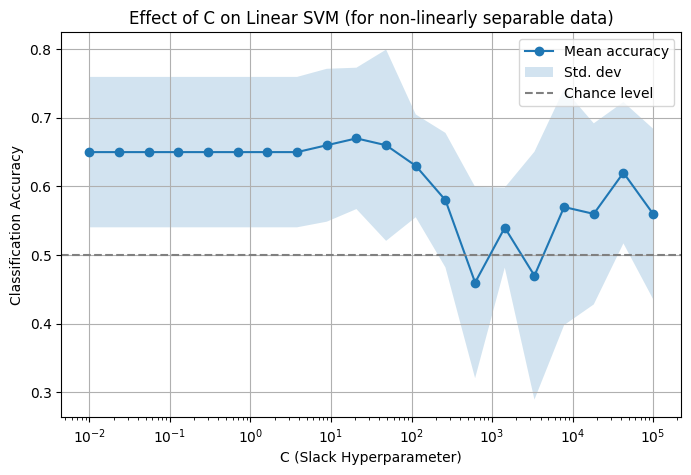

In [64]:
# make non-linearly separable data with 2 features; the larger std. deviation creates this
X,y = make_blobs(n_samples=100,n_features =2,centers=[[-1,0],[1,0]],cluster_std=1.5)

n_splits = 5 # train on 80%, test on 20%
avg_performance = []
std_performance = []

# define different slack hyperparameter values
c_values = np.logspace(-2, 5, 20)


for level in c_values:
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_performance = []
    
    
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = svm.LinearSVC(C=level, max_iter=1000)
        clf.fit(X_train, y_train)
        fold_performance.append(clf.score(X_test, y_test))

    avg_performance.append(np.mean(fold_performance))
    std_performance.append(np.std(fold_performance))

avg_performance = np.asarray(avg_performance)
std_performance = np.asarray(std_performance)
        
        
# Plotting
plt.figure(figsize=(8, 5))
plt.semilogx(c_values, avg_performance, marker='o', label='Mean accuracy')
plt.fill_between(c_values, avg_performance - std_performance,
                 avg_performance + std_performance, alpha=0.2, label='Std. dev')
plt.xlabel('C (Slack Hyperparameter)')
plt.ylabel('Classification Accuracy')
plt.title('Effect of C on Linear SVM (for non-linearly separable data)')
plt.axhline(y=0.5, linestyle='--', color='gray', label='Chance level')
plt.legend()
plt.grid(True)
plt.show()
    


**Report**

To answer this question, I used make_blobs() to create linearly non-separable data (i.e. by having a larger standard deviation (1.5), which causes clusters to overlap more). I then looped through different slack hyperparameter (C) values, and computed linear SVMs each time, adding the results to an array of average performance values and corresponding standard deviations. To assess performance, I used cross-validation, where I trained the model on 80% of the data and tested it on 20%.

**Results**
The plot above indicates the folowing trend:
- At low values of C smaller than 1, the performance remains relatively stable (around 0.65).
- At C values above 1, it then slightly increases.
- At C = 100, there is then a sharp drop in performance, which ultimately dips below chance level around C = 1000.

As such, performance generally decreases with higher C values for linear SVM on linearly non-separable data. A possible reason for why performance remains stable at lower C values is that the generated data is still very clean and that overlap is not very high, since the standard deviation could be higher. In fact, I initially did the exercise with standard deviation = 0.8, where I observed much higher performance levels early on (0.9), but the stable trend was still there. As such, the linear SVM still works well for a range of C values on non-separable data, until C becomes so large that it forced the model to overfit. 

The best C value here, approximately, would be around 50, but it should not be higher, as steep drop-off in performance happens around C = 100.  

### Exercise 2
---
Repeat exercise 1, but using a non-linear SVM model (the sklearn class `SVC` uses [Radial Basis Functions](https://en.wikipedia.org/wiki/Radial_basis_function) as a default, check its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)). 
To have a fairer assessment of the performance, train the model on a fraction (e.g. 80%) of the data, and test it on the other 20%.
Compare the performance of a linear SVC and a RBF SVC for dataset that are increaslingly non-linearly-separable.


### Exercise 3
---
Use the code below to simulate new data.
Generate data and then decode the stimulus identity, see how the decoding performance change when you change the following:

- The amplitude of the noise in the firing rate
- The amplitude of the stimulus modulation of the firing rate
- The number of neurons

Plot and comment.

## Useful code
---


In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [60]:
n_cells = 20; # number of cells to simulate
n_stim_type = 2; # number of different stimuli
sigma_stim = 0.5 # amplitude of stimulus related modulation
average_firing_rate = 5; # average firing rate across the population

# generate baseline rates from exponential distirbution
cell_rate_baseline = np.random.exponential(average_firing_rate,size=n_cells)

# create stimulus average responses, perturbing the population firng rate profile
# we use a multiplicative modulation in opposite directions for the two stimuli
modulation = sigma_stim*np.random.normal(0,1,size=n_cells)
cell_rate_stim = {1: cell_rate_baseline * (1+modulation),2:cell_rate_baseline * (1-modulation)}
# sets negative firng rate to 0
cell_rate_stim[1][cell_rate_stim[1]<0]=0
cell_rate_stim[2][cell_rate_stim[2]<0]=0

In [63]:
# simulate spiking activity

s_rate = 10000 # the sampling rate of our emulated recording system
noise_rate = 1 # we are going to add some spike noise non related to the task
n_stim = 100 # number of stimuli

stim_dur = 2 #stimulus duration (in seconds)
is_interval = 3 # interval between stimuli  (in seconds)

stim_onsets = np.arange(0,n_stim*(stim_dur+is_interval),(stim_dur+is_interval)) # onset time of each stimulus (in seconds)
stim_type = np.asarray([1 for i in range(int(n_stim/2))]+[2 for i in range(int(n_stim/2))]) # identity of each stimulus
np.random.shuffle(stim_type)

time = np.arange(0,(n_stim+1)*(stim_dur+is_interval),1.0/s_rate) # vector of the sampled times.

spike_times = []
for cell in range(n_cells):
    spikes = np.random.poisson(cell_rate_baseline[cell]/s_rate,size=time.shape)
    for i,stimulus in enumerate(stim_type):
        stim_idxs = np.arange(stim_onsets[i]*s_rate,(stim_onsets[i]+stim_dur)*s_rate)
        spikes[stim_idxs] = np.random.poisson(cell_rate_stim[stimulus][cell]/s_rate,size=stim_idxs.shape)

    spike_times.append(time[spikes>0])



In [73]:
# save ouput
out_dict = {'spike_times':spike_times,
            'stim_onsets':stim_onsets,
            'stim_type':stim_type,
            'stim_duration':stim_dur
            }

with open('data/simulated_data1.pickle', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
